In [22]:
import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
import matplotlib.dates as dates

In [23]:
import uncertainties.unumpy as unp
import uncertainties as unc

In [24]:
import geopandas as gpd

### Functions

In [25]:
def powerlaw(x, amplitude, exponent):
    return amplitude * x**(exponent)

In [26]:
def exponential(x, amplitude, tau):
    return amplitude * np.exp(x/tau)

In [27]:
def gauss(x, amplitude, mean, sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

### Import

In [28]:
dfr = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
dfp = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-province.json')
df = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [45]:
dfp['data'] = pd.to_datetime(dfp['data'])
dfr['data'] = pd.to_datetime(dfr['data'])
df['data'] = pd.to_datetime(df['data'])

In [34]:
fr = 'italia/Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp'
mapr_df = gpd.read_file(fr)

fp = 'italia/Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp'
mapp_df = gpd.read_file(fp)

In [ ]:
dfp = dfp.set_index('denominazione_provincia').join(mapp_df.set_index('DEN_PCM').geometry)
dfr = dfr.set_index('denominazione_regione').join(mapr_df.set_index('DEN_REG').geometry)

# ITALIA

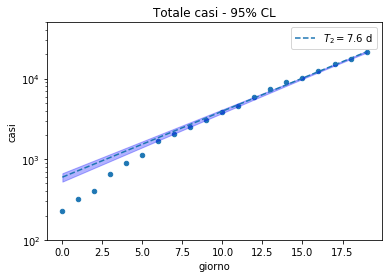

In [48]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='totale_casi', ax = ax, logy = True, title = 'Totale casi - 95% CL', ylim = [10**2,0.5*10**5])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.totale_casi[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('casi')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(max(df.data).date), dpi = 300)

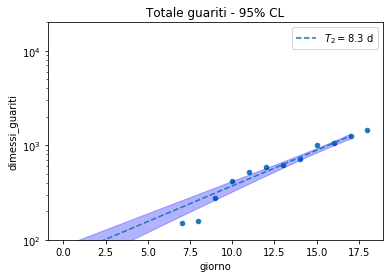

In [10]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 6

df.reset_index().plot.scatter(x='index',y='dimessi_guariti', ax = ax, logy = True, title = 'Totale guariti - 95% CL', ylim=[10**2,2*10**4])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.dimessi_guariti[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_guariti.png', dpi = 300)

# Province

## Singola Provincia

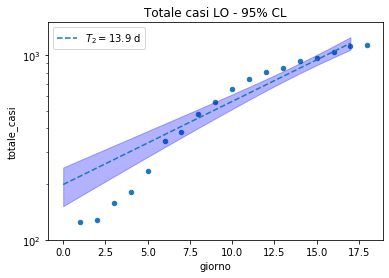

In [16]:
provincia = 'LO'

fig, ax = plt.subplots()

x = np.arange(19)
px = np.arange(20)
dd = 1

dfp[dfp.sigla_provincia == provincia].reset_index().reset_index().plot.scatter(x='level_0',y='totale_casi', ax = ax, logy = True, title = 'Totale casi {} - 95% CL'.format(provincia), ylim=[10**2,1.5*10**3])

popt, pcov = optimize.curve_fit(exponential, x[dd:], dfp[dfp.sigla_provincia == provincia].totale_casi[dd:])
y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#poptg, pcovg = optimize.curve_fit(gauss, x[:], dfp[dfp.sigla_provincia == provincia].totale_casi[:], p0=[1000,20,7])
#ax.plot(px[:16],gauss(px[:16], *poptg), ls = '--', label = 'gauss', color = 'red')

#ax.scatter(14, exponential(14, *popt), color = 'red')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(provincia), dpi = 300)

In [ ]:
dfp[dfp.sigla_provincia == provincia].to_csv('pr.csv')

## Analisi Province

In [36]:
province = np.unique(dfp[dfp.sigla_provincia != ''].sigla_provincia.values)
regioni = np.unique(dfp[dfp.denominazione_regione != ''].denominazione_regione.values)

In [37]:
time = max(dfp.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

df_forecast = dfp[(dfp.data == max(dfp.data.values)) & (dfp.sigla_provincia != '')]
df_forecast.loc[:,'data'] = time
sLength = len(df_forecast['data'])
df_forecast = df_forecast.assign(std = np.zeros(sLength))
#df_forecast.head()

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [38]:
for pr in province:
    df_temp = dfp[dfp.sigla_provincia == pr]
    #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
    df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    
    try:
        x = df_temp[df_temp.totale_casi > 0].data.values - min(df_temp[df_temp.totale_casi > 0].data.values)
        y = df_temp[df_temp.totale_casi > 0].totale_casi.values
        popt, pcov = optimize.curve_fit(exponential, x, y)

        y0,tau = unc.correlated_values(popt, pcov)
        py = y0*unp.exp((max(x)+1)/tau)

        nom = py.nominal_value
        std_new = py.std_dev
    except:
        nom = 0
        std_new = 0
    
    df_forecast.loc[df_forecast.sigla_provincia == pr,['totale_casi','std']] = nom, std_new
    
    

In [41]:
df_forecast.to_csv('forecast_province_2020.03.15.csv')
df_forecast.totale_casi.sum()

25827.573439498792

In [63]:
merged = mapp_df.set_index('DEN_PCM').join(df_forecast.set_index('denominazione_provincia'))

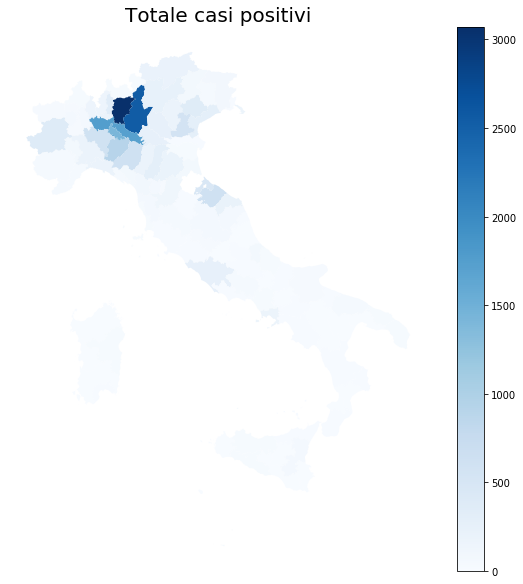

In [64]:
variable = 'totale_casi'
vmin, vmax  = 0, max(merged[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

merged.plot(column = variable, cmap = 'Blues', ax = ax);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(scale)
plt.savefig('map.png', dpi = 300, bbox_inches = 'tight')

In [29]:
for reg in regioni:
    province = df_forecast[df_forecast.denominazione_regione == reg].denominazione_provincia.values
    if len(province)>4:
        col = 3
    elif len(province)>2:
        col = 2
    else: 
        col = 1
    row = int(len(province)/col) + (len(province)%col > 0) 
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12, 12), constrained_layout=True)
    day0, day1 = min(dfp.data.values) - np.timedelta64(1,'D'), max(dfp.data.values) + np.timedelta64(2,'D')

    if len(province)>1:
        for pr, ax in zip(province, axes.flat):
            x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
            y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
            yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
            ax.scatter(x,y, color = 'red', s = 30)
            ax.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

            dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = ax, title = pr, xlim =[day0,day1])
            locator = dates.AutoDateLocator(minticks=5, maxticks=7)
            formatter = dates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('')
            ax.set_ylabel('')
    else:
        x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
        y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
        yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
        axes.scatter(x,y, color = 'red', s = 30)
        axes.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

        dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = axes, title = pr, xlim =[day0,day1])
        locator = dates.AutoDateLocator(minticks=5, maxticks=7)
        formatter = dates.ConciseDateFormatter(locator)
        axes.xaxis.set_major_locator(locator)
        axes.xaxis.set_major_formatter(formatter)
        axes.set_xlabel('')
        axes.set_ylabel('')
        
    fig.suptitle('Regione ' + reg, size = 14)
    for i in range(len(province),row*col):
        fig.delaxes(axes.flat[i])
    fig.savefig('plot/Regione_'+reg+'_'+str(max(dfp.data.values))+'.png', dpi = 200)
    plt.close()